# Google Trends vs Markets & Macro

Explore whether **Google search popularity** relates to **Tesla stock**, **Bitcoin price**, and **U.S. unemployment**. Data CSVs should be in the `data/` subfolder.


## Import Statements

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pd.options.display.float_format = '{:,.2f}'.format

## Read the Data

In [11]:
df_tesla = pd.read_csv('data/TESLA Search Trend vs Price.csv', parse_dates=['MONTH'])
df_btc_search = pd.read_csv('data/Bitcoin Search Trend.csv', parse_dates=['MONTH'])
df_btc_price = pd.read_csv('data/Daily Bitcoin Price.csv', parse_dates=['DATE'])
df_unemployment = pd.read_csv('data/UE Benefits Search vs UE Rate 2004-19.csv', parse_dates=['MONTH'])

for name, df in [('Tesla', df_tesla), ('BTC Search', df_btc_search), ('BTC Price', df_btc_price), ('Unemployment', df_unemployment)]:
    print(f"{name} shape: {df.shape} | columns: {list(df.columns)}")

Tesla shape: (124, 3) | columns: ['MONTH', 'TSLA_WEB_SEARCH', 'TSLA_USD_CLOSE']
BTC Search shape: (73, 2) | columns: ['MONTH', 'BTC_NEWS_SEARCH']
BTC Price shape: (2204, 3) | columns: ['DATE', 'CLOSE', 'VOLUME']
Unemployment shape: (181, 3) | columns: ['MONTH', 'UE_BENEFITS_WEB_SEARCH', 'UNRATE']


## Quick Checks & Stats

In [12]:
print('df_tesla:', df_tesla.shape, list(df_tesla.columns))
print('df_btc_search:', df_btc_search.shape, list(df_btc_search.columns))
print('df_btc_price:', df_btc_price.shape, list(df_btc_price.columns))
print('df_unemployment:', df_unemployment.shape, list(df_unemployment.columns))

df_tesla_stats = df_tesla.describe(include=[float, int])
print('Tesla search min/max:', df_tesla_stats.loc['min','TSLA_WEB_SEARCH'], df_tesla_stats.loc['max','TSLA_WEB_SEARCH'])

df_ue_stats = df_unemployment.describe(include=[float, int])
print('UE search min/max:', df_ue_stats.loc['min','UE_BENEFITS_WEB_SEARCH'], df_ue_stats.loc['max','UE_BENEFITS_WEB_SEARCH'])

df_btc_search_stats = df_btc_search.describe(include=[float, int])
print('BTC search min/max:', df_btc_search_stats.loc['min','BTC_NEWS_SEARCH'], df_btc_search_stats.loc['max','BTC_NEWS_SEARCH'])

df_btc_price_stats = df_btc_price.describe(include=[float, int])
print('BTC price min/max:', df_btc_price_stats.loc['min','CLOSE'], df_btc_price_stats.loc['max','CLOSE'])

df_tesla: (124, 3) ['MONTH', 'TSLA_WEB_SEARCH', 'TSLA_USD_CLOSE']
df_btc_search: (73, 2) ['MONTH', 'BTC_NEWS_SEARCH']
df_btc_price: (2204, 3) ['DATE', 'CLOSE', 'VOLUME']
df_unemployment: (181, 3) ['MONTH', 'UE_BENEFITS_WEB_SEARCH', 'UNRATE']
Tesla search min/max: 2.0 31.0
UE search min/max: 14.0 100.0
BTC search min/max: 3.0 100.0
BTC price min/max: 178.102997 19497.400391


## Missing Values

In [13]:
print('Missing Tesla?', df_tesla.isna().any().any())
print('Missing U/E?', df_unemployment.isna().any().any())
print('Missing BTC Search?', df_btc_search.isna().any().any())
print('Missing BTC Price?', df_btc_price.isna().any().any())

# Drop missing BTC prices if any
df_btc_price = df_btc_price.dropna().copy()

Missing Tesla? False
Missing U/E? False
Missing BTC Search? False
Missing BTC Price? True


## Align Bitcoin Price & Search by Month (Fix for NaN axis issue)

In [14]:
# Normalize search MONTH to month-start
df_btc_search['MONTH'] = pd.to_datetime(df_btc_search['MONTH']).dt.to_period('M').dt.to_timestamp(how='start')

# Resample BTC price to month-start (take last available close within that period)
df_btc_monthly = (
    df_btc_price
    .set_index('DATE')
    .resample('MS')  # Month Start
    .last()
    .reset_index()
    .rename(columns={'DATE': 'MONTH'})
)

# Merge aligned series
btc_merged = (
    pd.merge(
        df_btc_monthly[['MONTH', 'CLOSE']],
        df_btc_search[['MONTH', 'BTC_NEWS_SEARCH']],
        on='MONTH',
        how='inner'
    ).sort_values('MONTH')
)

print('BTC monthly (resampled):', df_btc_monthly.shape)
print('BTC merged (aligned):', btc_merged.shape)
print(btc_merged.head())

if btc_merged.empty:
    raise ValueError("No overlapping months between BTC price and search. Check MONTH parsing and column names.")

BTC monthly (resampled): (73, 3)
BTC merged (aligned): (73, 3)
       MONTH  CLOSE  BTC_NEWS_SEARCH
0 2014-09-01 386.94                5
1 2014-10-01 338.32                4
2 2014-11-01 378.05                4
3 2014-12-01 320.19                4
4 2015-01-01 217.46                5


## Tesla: Web Search vs Price

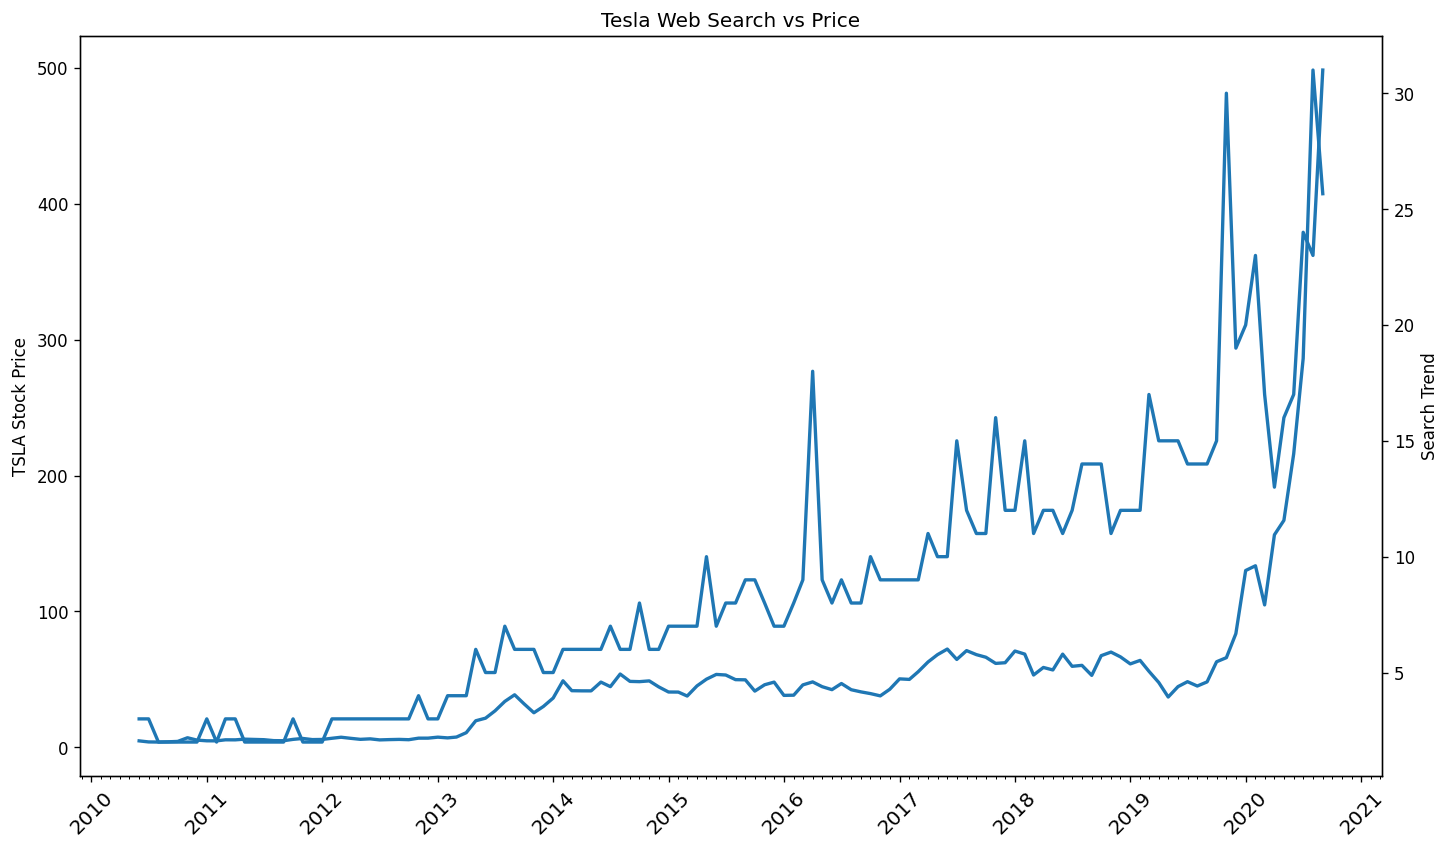

In [15]:
plt.figure(figsize=(14,8), dpi=120)
plt.title('Tesla Web Search vs Price')
plt.xticks(fontsize=12, rotation=45)

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.set_ylabel('TSLA Stock Price')
ax2.set_ylabel('Search Trend')

ax1.plot(df_tesla['MONTH'], df_tesla['TSLA_USD_CLOSE'], linewidth=2, label='TSLA Close')
ax2.plot(df_tesla['MONTH'], df_tesla['TSLA_WEB_SEARCH'], linewidth=2, label='Search')

years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)

plt.show()

## Bitcoin: News Search vs Resampled Price

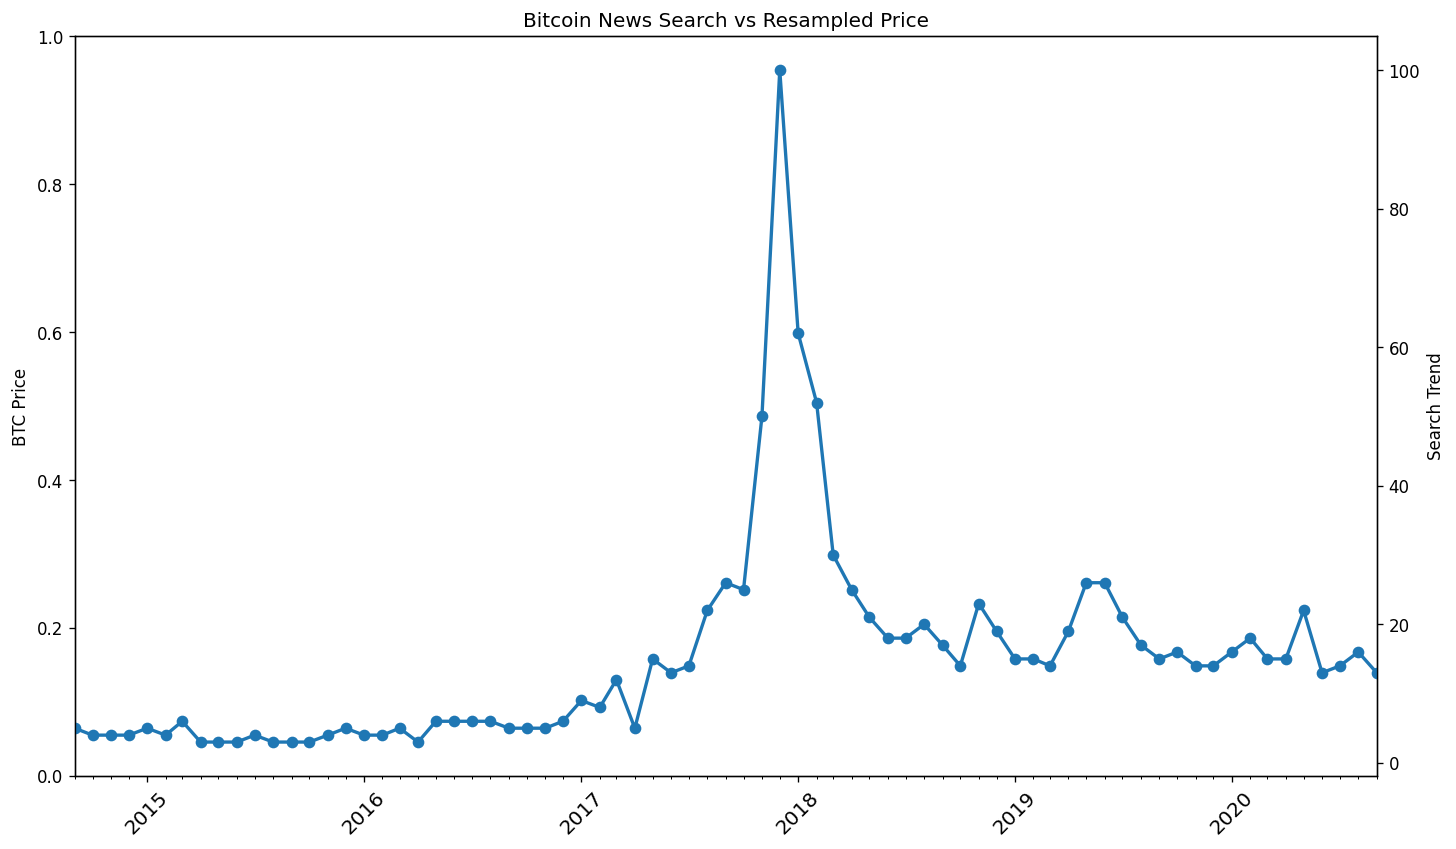

In [16]:
plt.figure(figsize=(14,8), dpi=120)
plt.title('Bitcoin News Search vs Resampled Price')
plt.xticks(fontsize=12, rotation=45)

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.set_ylabel('BTC Price')
ax2.set_ylabel('Search Trend')

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)

ax1.set_xlim([btc_merged['MONTH'].min(), btc_merged['MONTH'].max()])
ax1.set_ylim(bottom=0)

ax1.plot(btc_merged['MONTH'], btc_merged['CLOSE'], linewidth=2, linestyle='--', label='BTC Close')
ax2.plot(btc_merged['MONTH'], btc_merged['BTC_NEWS_SEARCH'], linewidth=2, marker='o', label='BTC Search')

plt.show()

## Unemployment Benefits Search vs Unemployment Rate (6‑Month Rolling)

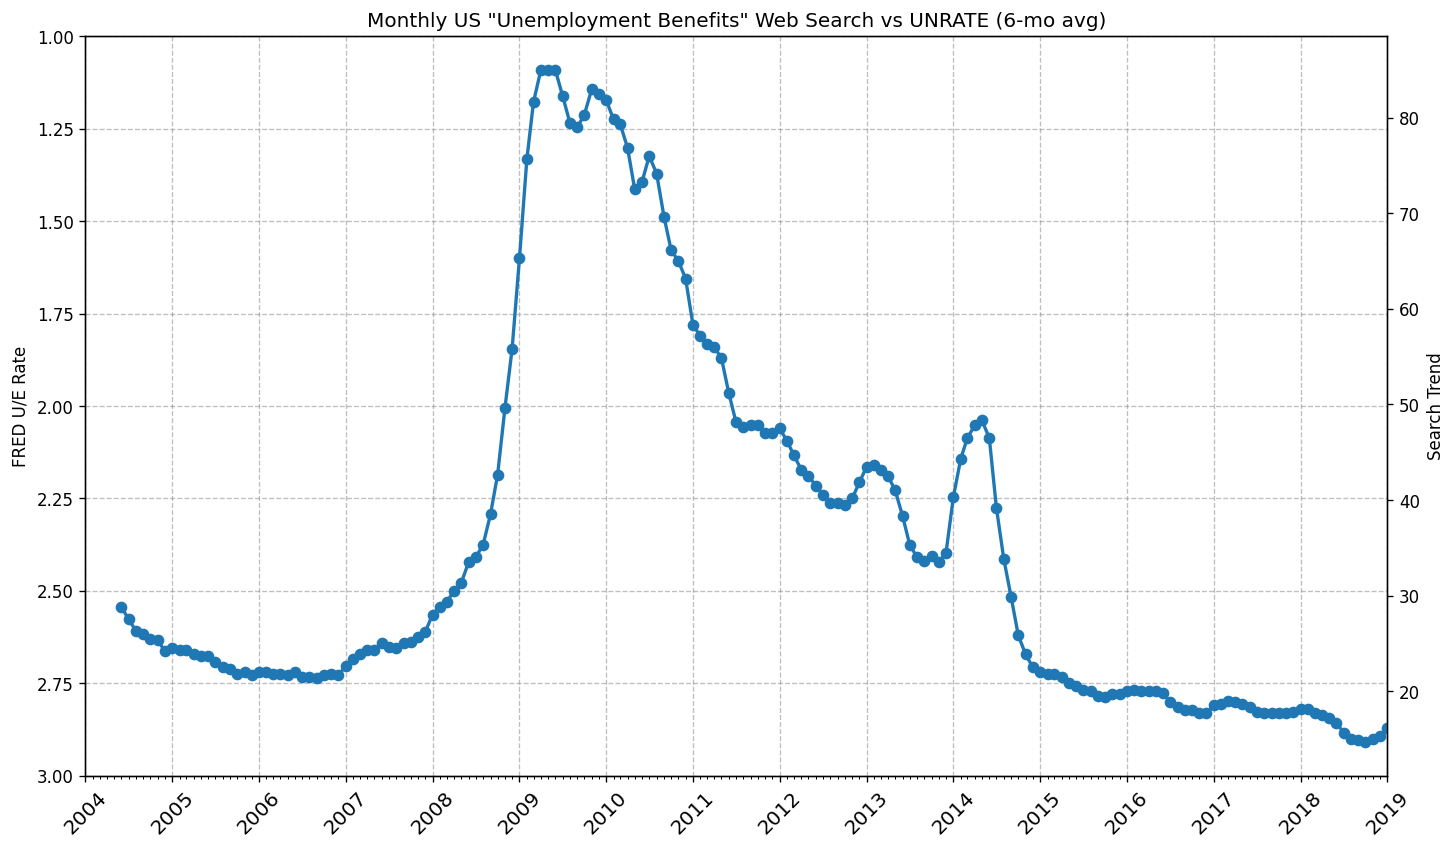

In [17]:
plt.figure(figsize=(14,8), dpi=120)
plt.title('Monthly US "Unemployment Benefits" Web Search vs UNRATE (6‑mo avg)')
plt.xticks(fontsize=12, rotation=45)

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.set_ylabel('FRED U/E Rate')
ax2.set_ylabel('Search Trend')

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)

ax1.set_ylim(bottom=3)
ax1.set_xlim([df_unemployment['MONTH'].min(), df_unemployment['MONTH'].max()])
ax1.grid(color='grey', linestyle='--', alpha=0.5)

roll_df = df_unemployment.set_index('MONTH')[['UE_BENEFITS_WEB_SEARCH','UNRATE']].rolling(window=6).mean()
ax1.plot(roll_df.index, roll_df['UNRATE'], linewidth=2, linestyle='--', label='UNRATE (6m avg)')
ax2.plot(roll_df.index, roll_df['UE_BENEFITS_WEB_SEARCH'], linewidth=2, marker='o', label='Search (6m avg)')

plt.show()

## Include 2020 Data

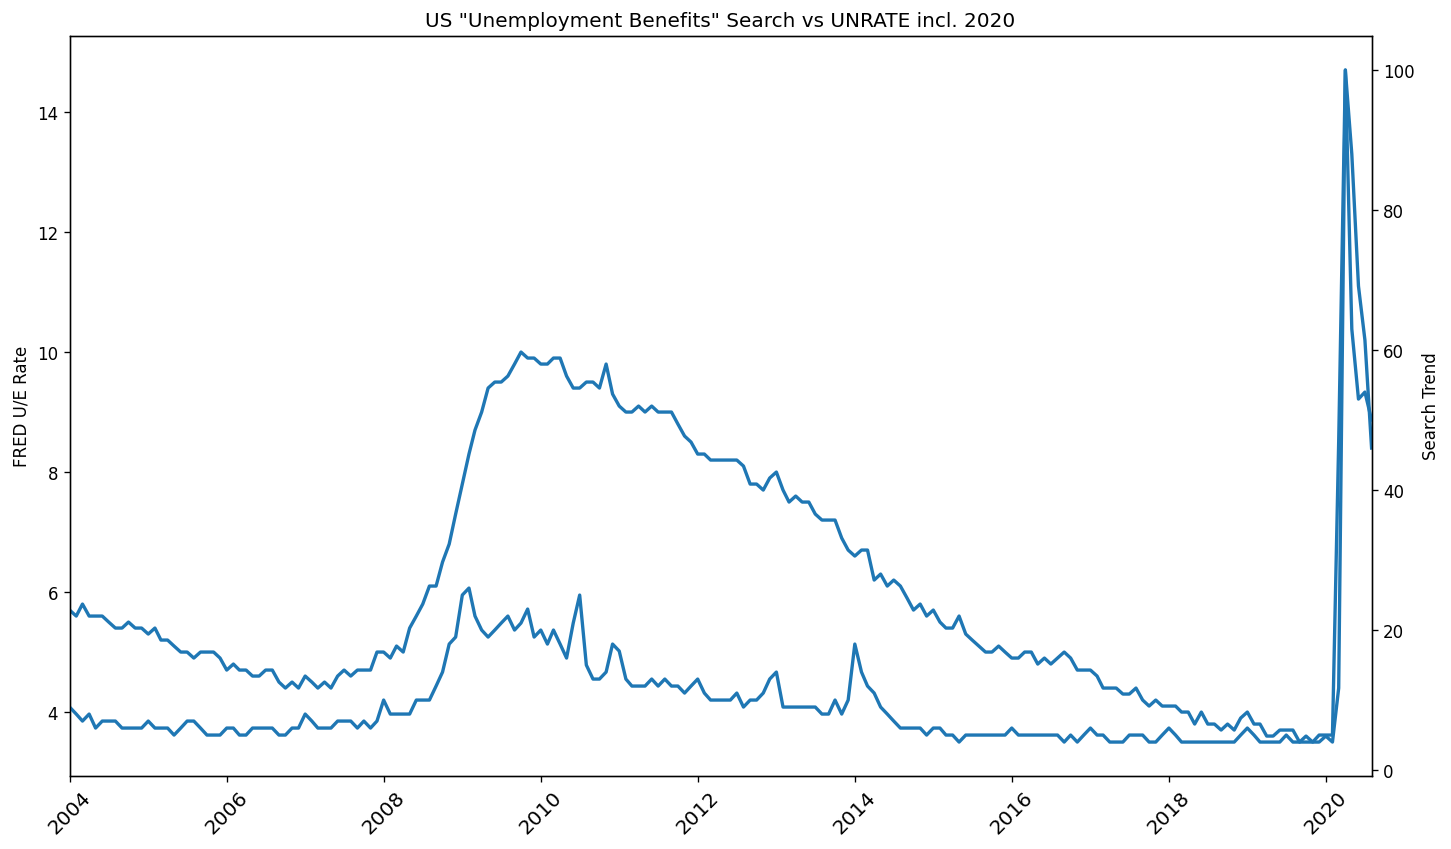

In [18]:
try:
    df_ue_2020 = pd.read_csv('data/UE Benefits Search vs UE Rate 2004-20.csv', parse_dates=['MONTH'])
    plt.figure(figsize=(14,8), dpi=120)
    plt.title('US "Unemployment Benefits" Search vs UNRATE incl. 2020')
    plt.xticks(fontsize=12, rotation=45)
    ax1 = plt.gca(); ax2 = ax1.twinx()
    ax1.set_ylabel('FRED U/E Rate'); ax2.set_ylabel('Search Trend')
    ax1.set_xlim([df_ue_2020['MONTH'].min(), df_ue_2020['MONTH'].max()])
    ax1.plot(df_ue_2020['MONTH'], df_ue_2020['UNRATE'], linewidth=2, label='UNRATE')
    ax2.plot(df_ue_2020['MONTH'], df_ue_2020['UE_BENEFITS_WEB_SEARCH'], linewidth=2, label='Search')
    plt.show()
except FileNotFoundError:
    print('Optional file not found: data/UE Benefits Search vs UE Rate 2004-20.csv')

## Conclusion

- **Tesla:** Search interest often spikes around major price moves, but timing is not always perfect.  
- **Bitcoin:** Search interest tends to surge with large rallies; overlap exists but isn’t strictly predictive.  
- **Unemployment:** Searches for *unemployment benefits* closely track the unemployment rate, especially in shock periods.  

Google Trends is a helpful proxy for public attention and a useful context layer for markets & macro series.
